In [1]:
import numpy as np
import matplotlib
#allow for latex markup in matplotlib figures
matplotlib.rcParams['text.usetex'] = False
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap


#Import a few utility functions...
import sys  
from pathlib import Path
sys.path.insert(0, "../comm_channel")
sys.path.insert(0, "../polling_systems")
sys.path.insert(0, "../geometry")
sys.path.insert(0, "../utils")

#So we can import my local libs
import CommChannel as CC
import qos
import pointcloud as PC
import PollingSystem as PS
import MarkovianRP as MRP
import dtr
import motion
import sim_template as sim
from importlib import reload 
import TSPN

In [2]:
#setup quality of service requirements using reasonable values
F5GHz, F2_4GHz = 5, 2.4 #typical wifi frequencies are 2.4, 5, and sometiems 6 GHz
MOBILE_TX_POWER = qos.Pwr(20)#100-200mW (20-23 dBm) pretty typical, with 1W (30dBm) the absolute maximum
print(MOBILE_TX_POWER)
r = 8#any of 2, 4, 6, or 8
rx_noise = qos.Pwr(-85)#based on Yan and MostofiTWC13 #1e-10#
print(rx_noise)
BER = 1e-6
GAMMA_TH = qos.QoSReq(BER, r, rx_noise).thresholdChannelGain(MOBILE_TX_POWER)
print(GAMMA_TH)
print('SNR Threshold: %d'%(GAMMA_TH+MOBILE_TX_POWER.dBm - rx_noise.dBm))

20.000000 dBm	-10.000000 dBW	100.000000 mW	0.100000 W
-85.000000 dBm	-115.000000 dBW	0.000000 mW	0.000000 W
-71.8297512825111
SNR Threshold: 33


In [3]:
#If we're feeling it
if False:
    %store -r dt_sys AORP TSPNP tjcps pjcps qBase region pcs pfs pjcps prob_pred_con ccs cfs true_joint_con_fields tjcps

In [4]:
#Setup the communication environment:

#For now, use same channel params, basd on the San Francisco measurements
nPL = 5.2 # per SF data should be in [2, 10]
kPL = -20 # per SF data, [-20, 90]

decorrSH = 2.09    
alpha = 16 # per SF data [4,100]%too high - worse prediction
sigmaSH = np.sqrt(alpha)
psdAtFC = 30

lam = 0.125
kRic = 10
decorrMP = 0.4*lam         
corrMP = 1
#sigmaMP = 3
sigmaMP = 1.5



#6 remote stations
l = 18
l_inner=10
c = np.array([30, 30])

qBase = np.array([c+l_inner*np.array([-(np.sqrt(3)/2), -1/2]), c+(l_inner+l)*np.array([-(np.sqrt(3)/2), -1/2]), 
                  c+l_inner*np.array([(np.sqrt(3)/2), -1/2]), c+(l_inner+l)*np.array([(np.sqrt(3)/2), -1/2]),
                  [30, 30+l_inner], [30, 30+l_inner+l]])


sub_regions = [[28, 4, 30, 5],
               [55, 35, 30, 5],
               [40, 22, 60, 35]]



cps = [CC.ChannelParams(qBase[i], nPL, kPL, sigmaSH, decorrSH, decorrMP, lam,
                      kRic, corrMP, psdAtFC, sigmaMP) for i in range(len(qBase))]

x_max = 60
x_min = 0
y_max = 60
y_min = 0
region = [x_max, x_min, y_max, y_min]

#res = 2/decorrMP
res = 10
n=3
p_th = 0.5

bandwidth = 2#leave bandwidth in MHz*1000000#give ourselfes 2MHz of BW
beta = 1/(r*bandwidth)
els = [0.3/beta, 0.01/beta, 0.01/beta]

#and set velocity
v = 1

In [5]:
reload(sim)
ccs, cfs, true_joint_con_fields, tjcps = sim.create_channels(cps, region, res, GAMMA_TH, sub_regions)

Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.


In [6]:
reload(sim)
pcs, pfs, pjcps, prob_pred_con = sim.predict_channels(res, ccs, true_joint_con_fields, GAMMA_TH, p_th=p_th)

print(prob_pred_con)

Drawing 600 samples from Channel 1
Completed PredictedChannel 1
Drawing 600 samples from Channel 2
Completed PredictedChannel 2
Drawing 500 samples from Channel 3
Completed PredictedChannel 3
Drawing 500 samples from Channel 4
Completed PredictedChannel 4
Drawing 450 samples from Channel 5
Completed PredictedChannel 5
Drawing 450 samples from Channel 6
Completed PredictedChannel 6
[0.8432974378017082, 0.7881818181818182, 0.7604679802955665]


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


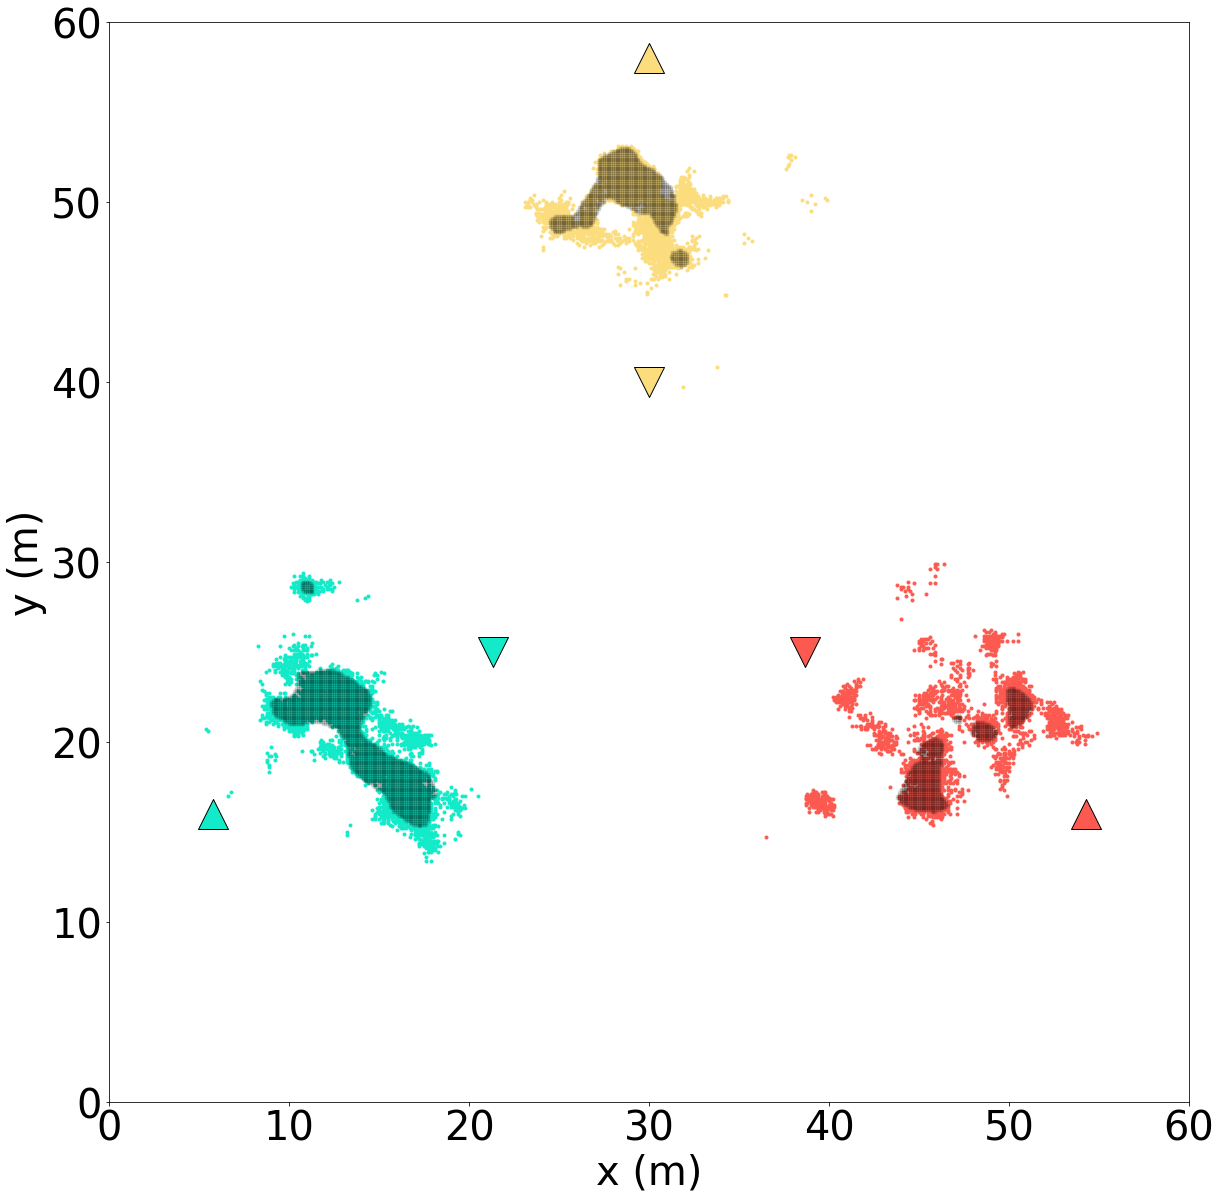

In [7]:
reload(sim)
sim.plotCFwithOverlay(n, tjcps, pjcps, qBase, region)
plt.gca().invert_yaxis()
plt.show()

In [8]:
dt_sys = dtr.DTR(pcs, region, els, beta, th = GAMMA_TH, p_th=p_th)
ps = dt_sys.ps

Extracted edges...
Polygons constructed, looking for holes...
Constructed 2 possibly non-convex polygons
13 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 4 possibly non-convex polygons
10 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 2 possibly non-convex polygons
10 total subregions


In [9]:

v = 1
sys_traffic = 0.5

rho1_percents = np.array([0.2, 1/3, 0.8])

Ws = []
W_cys = []
n_steps = 3
l = np.reshape(np.array([0,25,50]),(n_steps,1))
offsets = -1*l*np.array([np.cos(np.pi/6), np.sin(np.pi/6)])
regions = np.reshape(np.array([x_max, x_min, y_max, y_min]), (4,1)) + np.array([np.zeros(n_steps), offsets[:,0], np.zeros(n_steps), offsets[:,1]])
regions = regions.T

all_Xs = np.zeros((3,3,3,2))
all_pis = np.zeros((3,3,3))

In [10]:
#generate data & save data

reload(dtr)
reload(TSPN)
reload(sim)
reload(PS)



latex_table_str = ''

k = 0
for offset, tregion in zip(offsets, regions):
    dt_sys.shiftRegion(0, offset)
    dt_sys.region = tregion
    tjcps[0] += offset
    pjcps[0] += offset
    qBase[0] += offset
    qBase[1] += offset
    #find the TSPNP
    sys_regions = dt_sys.cregions
    tspn_min, tspn_argmin = TSPN.TSPN_BF(sys_regions)
    TSPNP={'X':tspn_argmin[0], 'SEQ':tspn_argmin[1]}
    S_cy = dtr.XtoS(TSPNP['X'])
    S_cyv = np.zeros(n)
    seq = TSPNP['SEQ']
    for i in range(n):
        S_cyv[i] = S_cy[seq[i], seq[(i+1)%n]]
    
    for j in range(len(rho1_percents)):
        rho1_prcnt = rho1_percents[j]
        others = (1-rho1_prcnt)/2
        els = np.array([rho1_prcnt, others, others])*sys_traffic/beta
        ps.Ls = els
        print("Finding AORP")
        AORP = sim.calc_AORP(dt_sys, v)
        print("Found AORP")
        pi = AORP['pi']
        S = dtr.XtoS(AORP['X'])
        all_pis[k,j] = pi
        all_Xs[k,j] = AORP['X']
        
        #S_i = S @ pi
        W_rnd = ps._calc_avg_wait_random(S, pi)
        W_cy = ps._calc_avg_wait_cyclic(S_cyv)
        Ws.append(W_rnd)
        W_cys.append(W_cy)
         
        #print(S)
        P_tilde, pi_tilde = sim.pi_to_P(pi)
        
        latex_table_str += ' & '
        for i in range(n):   
            latex_table_str += " %.2f & %.2f & "%(ps.Ls[i], pi_tilde[i])
        latex_table_str += "%.2f\\\\ \n \\hline \n"%(W_rnd)
    dt_sys.shiftRegion(0, -offset)#move back
    tjcps[0] -= offset
    pjcps[0] -= offset
    qBase[0] -= offset
    qBase[1] -= offset
    k += 1
print(latex_table_str)

if False:
    np.savez("fig_eq_trends__relay_regions", tjcps=tjcps, pjcps=pjcps)
    np.savez("fig_eq_trends__fig_4_data", all_xs = all_Xs, all_pis = all_pis)

Extracted edges...
Polygons constructed, looking for holes...
Constructed 2 possibly non-convex polygons
13 total subregions
Total of 1 Permutations to Try
Working on Permutation (0, 1, 2)
Optimal Solution Improved to 88.61
Elapsed Time: 0.23
Finding AORP
Found AORP
Finding AORP
Found AORP
Finding AORP


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Found AORP
Extracted edges...
Polygons constructed, looking for holes...
Constructed 2 possibly non-convex polygons
13 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 2 possibly non-convex polygons
13 total subregions
Total of 1 Permutations to Try
Working on Permutation (0, 1, 2)
Optimal Solution Improved to 134.81
Elapsed Time: 0.13
Finding AORP


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Found AORP
Finding AORP
Found AORP
Finding AORP
Found AORP
Extracted edges...
Polygons constructed, looking for holes...
Constructed 2 possibly non-convex polygons
13 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 2 possibly non-convex polygons
12 total subregions
Total of 1 Permutations to Try
Working on Permutation (0, 1, 2)
Optimal Solution Improved to 183.39
Elapsed Time: 0.12
Finding AORP


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Found AORP
Finding AORP
Found AORP
Finding AORP


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Found AORP
Extracted edges...
Polygons constructed, looking for holes...
Constructed 2 possibly non-convex polygons
13 total subregions
 &  1.60 & 0.28 &  3.20 & 0.37 &  3.20 & 0.34 & 89.91\\ 
 \hline 
 &  2.67 & 0.33 &  2.67 & 0.35 &  2.67 & 0.32 & 93.41\\ 
 \hline 
 &  6.40 & 0.49 &  0.80 & 0.27 &  0.80 & 0.23 & 60.44\\ 
 \hline 
 &  1.60 & 0.21 &  3.20 & 0.40 &  3.20 & 0.39 & 128.26\\ 
 \hline 
 &  2.67 & 0.27 &  2.67 & 0.37 &  2.67 & 0.36 & 138.85\\ 
 \hline 
 &  6.40 & 0.43 &  0.80 & 0.29 &  0.80 & 0.28 & 101.54\\ 
 \hline 
 &  1.60 & 0.18 &  3.20 & 0.42 &  3.20 & 0.41 & 165.46\\ 
 \hline 
 &  2.67 & 0.23 &  2.67 & 0.39 &  2.67 & 0.38 & 182.79\\ 
 \hline 
 &  6.40 & 0.39 &  0.80 & 0.31 &  0.80 & 0.30 & 142.46\\ 
 \hline 



/home/win/.local/lib/python3.8/site-packages/numpy/lib/npyio.py:719: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


In [11]:
#reload data if necessary
if True:
    rr_data = np.load("fig_eq_trends__relay_regions.npz", allow_pickle=True)
    tjcps = rr_data["tjcps"]
    pjcps = rr_data["pjcps"]

    fig4_data = np.load("fig_eq_trends__fig_4_data.npz", allow_pickle=True)
    all_Xs = fig4_data["all_xs"]
    all_pis = fig4_data["all_pis"]

Subplot 0, 0
[[0.         0.54927048 0.45072952]
 [0.41578701 0.         0.58421299]
 [0.36869577 0.63130423 0.        ]] [0.28220405 0.3728023  0.34499365]
Subplot 0, 1
[[0.         0.5425972  0.4574028 ]
 [0.52406819 0.         0.47593181]
 [0.48139469 0.51860531 0.        ]] [0.33495027 0.34679281 0.31825692]
Subplot 0, 1
[[0.         0.5425972  0.4574028 ]
 [0.52406819 0.         0.47593181]
 [0.48139469 0.51860531 0.        ]] [0.33495027 0.34679281 0.31825692]
Subplot 0, 2
[[0.         0.53763645 0.46236355]
 [0.98099492 0.         0.01900508]
 [0.97796905 0.02203095 0.        ]] [0.4948458  0.27120134 0.23395287]
Subplot 1, 1
[[0.         0.52823681 0.47176319]
 [0.37539439 0.         0.62460561]
 [0.34927881 0.65072119 0.        ]] [0.26611106 0.3744586  0.35943034]
Subplot 2, 1
[[0.         0.52348878 0.47651122]
 [0.30318901 0.         0.69681099]
 [0.28369992 0.71630008 0.        ]] [0.22695088 0.39185536 0.38119376]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


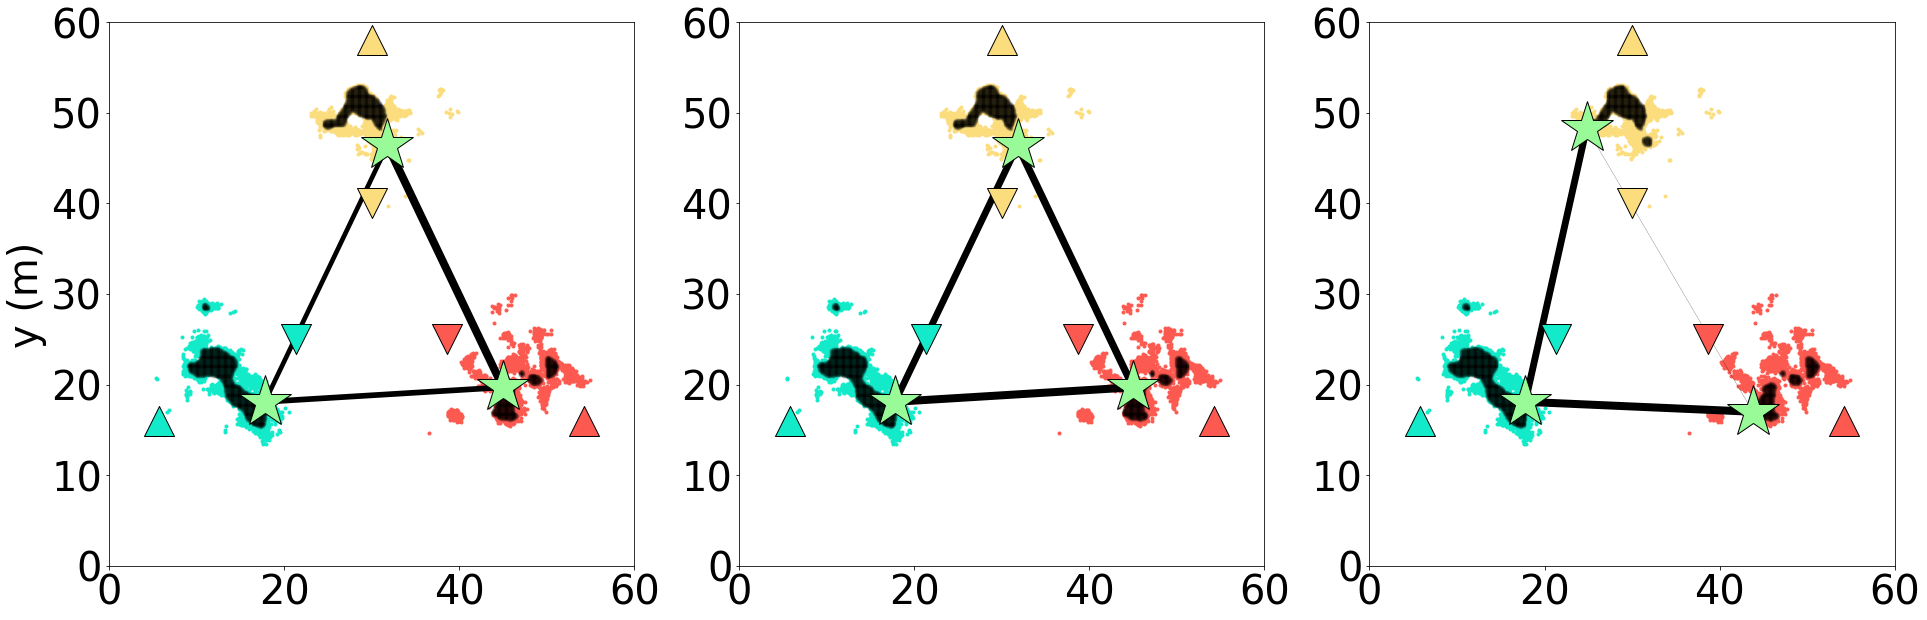

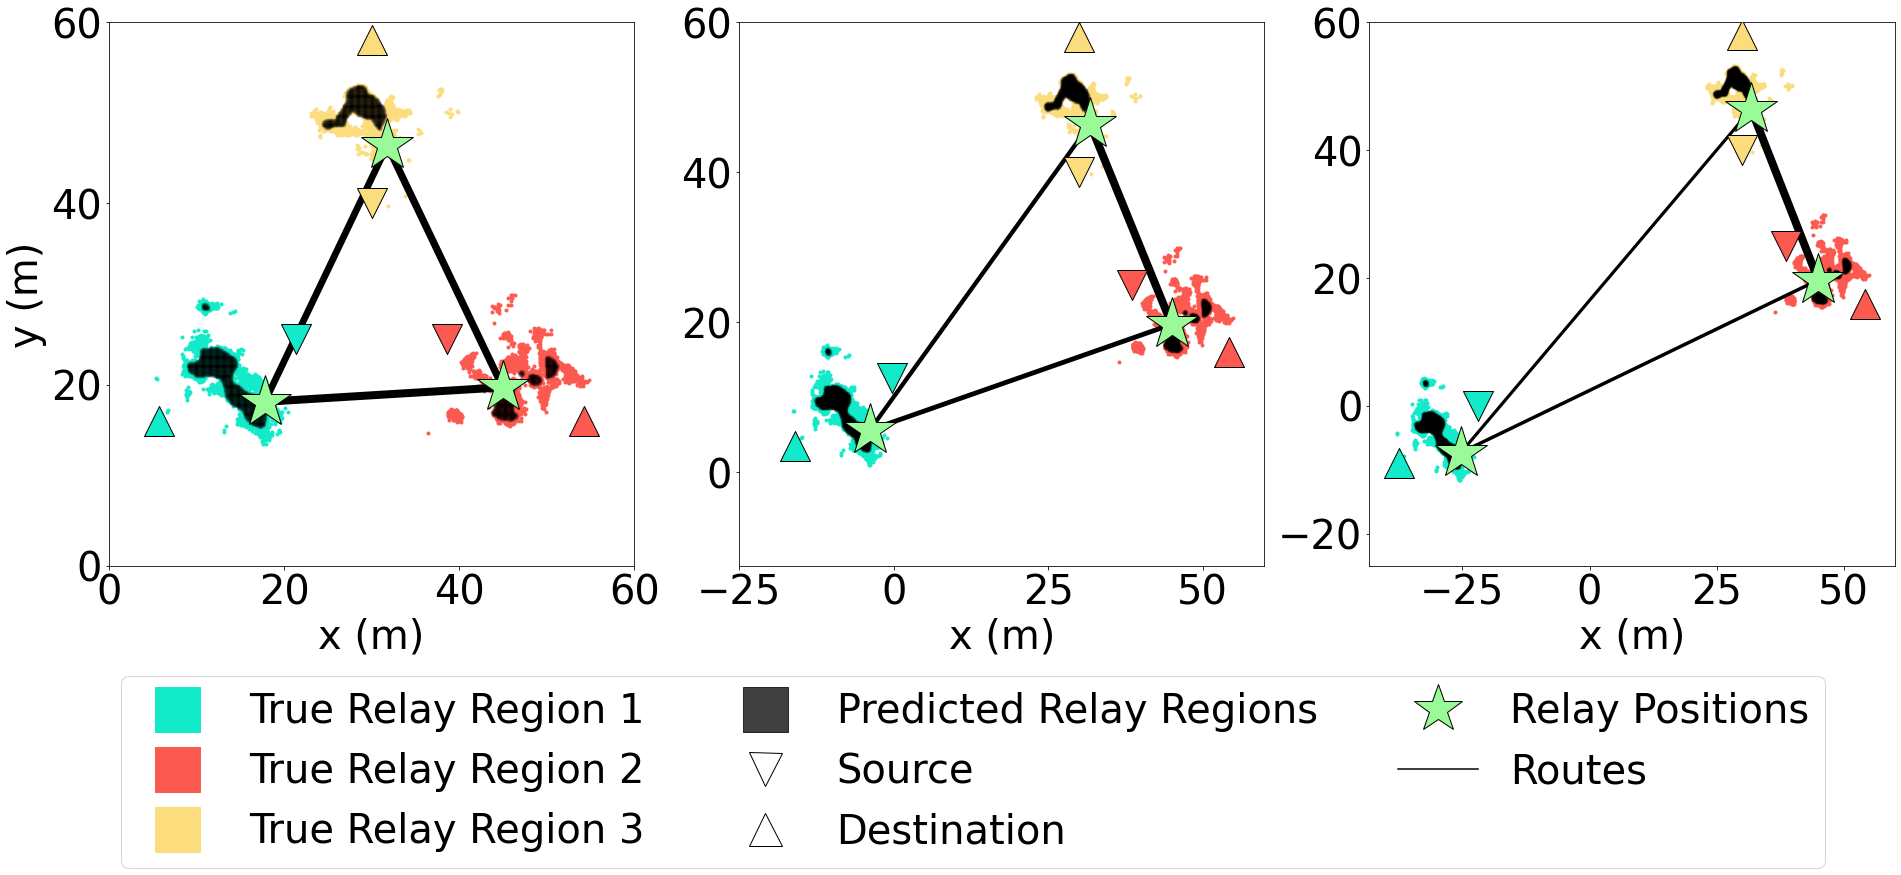

In [15]:
# Plot the Data
reload(sim)
v = 1


figA, axsA = plt.subplots(1,3, figsize=(32, 10))
figB, axsB = plt.subplots(1,3, figsize=(32, 10))
k = 0
for offset, tregion in zip(offsets, regions):
    tjcps[0] += offset
    pjcps[0] += offset
    qBase[0] += offset
    qBase[1] += offset
    for j in range(len(rho1_percents)):
        rho1_prcnt = rho1_percents[j]
        others = (1-rho1_prcnt)/2
        els = np.array([rho1_prcnt, others, others])*sys_traffic/beta
        
        AORP={"X": all_Xs[k,j], "pi": all_pis[k,j]}
        P_tilde, pi_tilde = sim.pi_to_P(AORP["pi"])
        #plot across varying arrival rates when regions are ~ equidistant
        if k == 0:
            ax = axsA[j]
            sim.plot_relay_regions(n, tjcps, pjcps, rhos = None, pi = None, ax = ax)
            sim.plot_bs(qBase, ax)
            sim.set_lims(tregion, ax)
            sim.plot_AORP_routes(AORP, ax)
            ax.invert_yaxis()
            if j == 0:
                ax.set_ylabel('y (m)')
            
            label1 = '$\\rho_%d = %.2f$, $\\tilde{\\pi}_%d = %.2f$'%(1, els[0]*beta, 1, pi_tilde[0])
            label2 = '$\\rho_%d = %.2f$, $\\tilde{\\pi}_%d = %.2f$'%(2, els[1]*beta, 2, pi_tilde[1])
            label3 = '$\\rho_%d = %.2f$, $\\tilde{\\pi}_%d = %.2f$'%(3, els[2]*beta, 3, pi_tilde[2])
            print("Subplot %d, %d"%(k,j))
            print(P_tilde, pi_tilde)
            label = label1 +"\n" + label2 + "\n" + label3
            #ax.annotate(label, xy=(0.5,0.02),xycoords='axes fraction',
#              fontsize=25)
        #plot across varying distances when arrival rates are ~ equidistant
        if j == 1:
            ax = axsB[k]
            sim.plot_relay_regions(n, tjcps, pjcps, rhos = None, pi = None, ax = ax)
            sim.plot_bs(qBase, ax)
            sim.set_lims(tregion, ax)
            sim.plot_AORP_routes(AORP, ax)#X, pi
            ax.invert_yaxis()
            if k == 0:
                ax.set_ylabel('y (m)')
                ax.set_yticks([0, 20, 40, 60])
            ax.set_xlabel('x (m)')
            
            if k==1:
                ax.set_xticks([-25, 0, 25, 50])
            elif k==2:
                ax.set_xticks([-25, 0, 25, 50])
            
            label1 = '$\\rho_%d = %.2f$, $\\tilde{\\pi}_%d = %.2f$'%(1, els[0]*beta, 1, pi_tilde[0])
            label2 = '$\\rho_%d = %.2f$, $\\tilde{\\pi}_%d = %.2f$'%(2, els[1]*beta, 2, pi_tilde[1])
            label3 = '$\\rho_%d = %.2f$, $\\tilde{\\pi}_%d = %.2f$'%(3, els[2]*beta, 3, pi_tilde[2])
            label = label1 +"\n" + label2 + "\n" + label3
            #ax.annotate(label, xy=(0.5,0.02),xycoords='axes fraction',
#              fontsize=25)
            print("Subplot %d, %d"%(k,j))
            print(P_tilde, pi_tilde)

    tjcps[0] -= offset
    pjcps[0] -= offset
    qBase[0] -= offset
    qBase[1] -= offset
    k += 1

    
    
handles, labels = axsB[2].get_legend_handles_labels()
figB.legend(handles, labels, loc='upper center', bbox_to_anchor=[0.5,0.00], ncol=3)

figA.savefig('fig3_variation_over_lambda.eps', format='eps', bbox_inches='tight')
figB.savefig('fig3_variation_over_position.eps', format='eps', bbox_inches='tight')
figA.savefig('fig3_variation_over_lambda.png', format='png', bbox_inches='tight')
figB.savefig('fig3_variation_over_position.png', format='png', bbox_inches='tight')

In [18]:
sys_traffic = 0.5
rho1_percents = np.array([0.1, 1/5, 1/4, 1/3, 1/2, 2/3, 3/4, 4/5, 0.9])
n_vals = len(rho1_percents)

Ws = []
W_cys = []
l = np.arange(0,60,10)
n_steps = len(l)
l = np.reshape(l,(n_steps,1))

offsets = -1*l*np.array([np.cos(np.pi/6), np.sin(np.pi/6)])
regions = np.reshape(np.array([x_max, x_min, y_max, y_min]), (4,1)) + np.array([np.zeros(n_steps), offsets[:,0], np.zeros(n_steps), offsets[:,1]])
regions = regions.T

In [62]:
#plot vs offset
reload(dtr)
reload(sim)

# dt_sys = dtr.DTR(pcs, region, els, beta, th = GAMMA_TH, p_th=p_th)
# ps = dt_sys.ps

pi1s = np.zeros((n_steps, n_vals))
pi1s_obs = np.zeros((n_steps, n_vals))
pis = np.zeros((n_steps, n_vals, 3))

all_Xs = []
Ws = np.zeros((n_steps, n_vals))
# for offset, tregion in zip(offsets, regions):
for i in range(n_steps):
    offset = offsets[i]
    tregion = regions[i]
    dt_sys.shiftRegion(0, offset)
    dt_sys.region = tregion

    offset_Xs = []
    for j in range(len(rho1_percents)):
        print("Iteration %d, %d"%(i,j))
        rho1_prcnt = rho1_percents[j]
        others = (1-rho1_prcnt)/2
        els = np.array([rho1_prcnt, others, others])*sys_traffic/beta
        ps.Ls = els

        AORP = sim.calc_AORP(dt_sys, v)
        pi = AORP['pi']
        offset_Xs.append(AORP['X'])
        pis[i,j] = pi
        S = dtr.XtoS(AORP['X'])
        #normalize
        #get observed
        P, pi_obs = sim.pi_to_P(pi)
        pi1s_obs[i,j] = pi_obs[0]
        pi1s[i,j] = pi[0]
        w_cur = ps._calc_avg_wait_random(S, pi)
        Ws[i,j] = w_cur
        if j>0:
            #check to see if we need to do some smoothing
            
            #maybe the current one is just low, so try a couple things
            if pi1s[i,j]<pi1s[i, j-1]:
                #Check double check that we're optimal at this scale value
                AORP = sim.calc_AORP(dt_sys, v)
                pi = AORP['pi']
                S = dtr.XtoS(AORP['X'])
                
                w_cur_new = ps._calc_avg_wait_random(S, pi)
                if w_cur_new <=w_cur:
                    Ws[i,j] = w_cur_new
                    #then this is truly more optimal, and we should use it
                    pis[i,j] = pi
                    P, pi_obs = sim.pi_to_P(pi)
                    offset_Xs[-1] = AORP['X']
                    #did it increase pi[0]?
                    if pi1s[i,j] < pi[0]:
                        print("Increased pi[0] from %.4f to %.4f"%(pi1s[i,j], pi[0]))
                    #regardless, this was a beter outcome
                    pi1s[i,j] = pi[0]
                    pi1s_obs[i,j] = pi_obs[0]
                    
                #Also check to see if using a smarter start helps
                AORP = sim.calc_AORP(dt_sys, v, X0 = offset_Xs[-2])
                pi = AORP['pi']
                S = dtr.XtoS(AORP['X'])
                w_cur_new = ps._calc_avg_wait_random(S, pi)
                if w_cur_new <=w_cur:
                    Ws[i,j] = w_cur_new
                    #then this is truly more optimal, and we should use it
                    pis[i,j] = pi
                    P, pi_obs = sim.pi_to_P(pi)
                    offset_Xs[-1] = AORP['X']
                    #did it increase pi[0]?
                    if pi1s[i,j] < pi[0]:
                        print("Increased pi[0] from %.4f to %.4f"%(pi1s[i,j], pi[0]))
                    #regardless, this was a beter outcome
                    pi1s[i,j] = pi[0]
                    pi1s_obs[i,j] = pi_obs[0]
                    
                #also check that we weren't just super high last time
                c = scale[j-1]
                els[0] =  c*base
                ps.Ls = els
    
                AORP = sim.calc_AORP(dt_sys, v)
                pi = AORP['pi']
                S = dtr.XtoS(AORP['X'])
                
                w_cur_new = ps._calc_avg_wait_random(S, pi)
                if w_cur_new <=w_cur:
                    #then this is truly more optimal, and we should use it
                    pis[i,j-1] = pi
                    P, pi_obs = sim.pi_to_P(pi)
                    offset_Xs[-2] = AORP['X']
                    #did it increase pi[0]?
                    if pi1s[i,j-1] < pi[0]:
                        print("Increased pi[0] from %.4f to %.4f"%(pi1s[i,j-1], pi[0]))
                    #regardless, this was a beter outcome
                    pi1s[i,j-1] = pi[0]
                    pi1s_obs[i,j-1] = pi_obs[0]
                    
                #Also check to see if using a smarter start helps
                if j>1:
                    AORP = sim.calc_AORP(dt_sys, v, X0 = offset_Xs[-3])
                    pi = AORP['pi']
                    S = dtr.XtoS(AORP['X'])
                    w_cur_new = ps._calc_avg_wait_random(S, pi)
                    if w_cur_new <=w_cur:
                         #then this is truly more optimal, and we should use it
                        pis[i,j-1] = pi
                        P, pi_obs = sim.pi_to_P(pi)
                        offset_Xs[-2] = AORP['X']
                        #did it increase pi[0]?
                        if pi1s[i,j-1] < pi[0]:
                            print("Increased pi[0] from %.4f to %.4f"%(pi1s[i,j-1], pi[0]))
                        #regardless, this was a beter outcome
                        pi1s[i,j-1] = pi[0]
                        pi1s_obs[i,j-1] = pi_obs[0]

                c = scale[j]
                els[0] =  c*base
                ps.Ls = els
                
            if pi1s[i,j]<pi1s[i, j-1]:#if it's still not better, print out some useful info
                print("weird spike detected")
                print("params", offset, c)
                print("Previous pi", pis[i, j-1])
                print("Current pi", pis[i, j])
                print("pi[0] should increase")
                print("Previous positions: ", offset_Xs[-2])
                print("Previous dists: ", dtr.XtoS(offset_Xs[-2]))
                print("Current positions: ", offset_Xs[-1])
                print("Current dists: ", dtr.XtoS(offset_Xs[-1]))
                print("Diff caused by shift?")
                
                print("can we do better using some of the past results?")
                S_prev = dtr.XtoS(offset_Xs[-2])
                W_rnd = ps._calc_avg_wait_random(S, pi)
                print("Current Wait Time: %.4f"%(W_rnd))
                #try with previous pi
                W_rnd = ps._calc_avg_wait_random(S, pis[i, j-1])
                print("Wait Time with prev pi: %.4f"%(W_rnd))
                #try with previous S
                print("Wait time with previous S: %.4f"%(W_rnd))
                W_rnd = ps._calc_avg_wait_random(S_prev, pi)
                #try with previous pi and S
                print("Wait time with previous S and pi: %.4f"%(W_rnd))
                W_rnd = ps._calc_avg_wait_random(S_prev, pis[i, j-1])
                
                #conjecture - it's due to initizliation, so we can try to
                #1 try again
                AORP = sim.calc_AORP(dt_sys, v)
                print("Recalc'd AORP", AORP)
                #2 also look at the old scenario again - perhaps it was too high
                c = scale[j-1]
                els[0] =  c*base
                ps.Ls = els
                AORP = sim.calc_AORP(dt_sys, v)
                print("Recalc'd prev AORP", AORP)
                
                #revert back
                c = scale[j]
                els[0] =  c*base
                ps.Ls = els
                #3 try inching up the probabilites using the previous location
                pi_test = pis[i, j-1]
                for k in range(20):
                    pi_test += np.array([0.005, -.0025, -.0025])
                    W_rnd = ps._calc_avg_wait_random(S_prev, pi_test)
                    print("Wait Time with more granular pi, old positions: %.4f"%(W_rnd), pi_test)

    dt_sys.shiftRegion(0, -offset)#move back
    all_Xs.append(offset_Xs)
    
#and save off, should we need it later
if False:
    np.savez("fig_eq_trends__fig_5_data", l=l, rho1_percents=rho1_percents, pi1s=pi1s, pi1s_obs=pi1s_obs)

Extracted edges...
Polygons constructed, looking for holes...
Constructed 3 possibly non-convex polygons
Info: Reduced Poly only contains two points. Reduction ignored
Poly: ([ 7.2 21.7])  ([ 7.2 21.6])  ([ 7.3 21.6])  ([ 7.3 21.7]) Is Interior: False
8 total subregions
Iteration 0, 0
Iteration 0, 1
Iteration 0, 2
Iteration 0, 3
Iteration 0, 4


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Iteration 0, 5


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Iteration 0, 6
Iteration 0, 7
Iteration 0, 8


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Extracted edges...
Polygons constructed, looking for holes...
Constructed 3 possibly non-convex polygons
Info: Reduced Poly only contains two points. Reduction ignored
Poly: ([ 7.2 21.7])  ([ 7.2 21.6])  ([ 7.3 21.6])  ([ 7.3 21.7]) Is Interior: False
8 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 3 possibly non-convex polygons
Info: Reduced Poly only contains two points. Reduction ignored
Poly: ([-1.46025404 16.7       ])  ([-1.46025404 16.6       ])  ([-1.36025404 16.6       ])  ([-1.36025404 16.7       ]) Is Interior: False
8 total subregions
Iteration 1, 0


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Iteration 1, 1
Iteration 1, 2


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Iteration 1, 3
Iteration 1, 4
Iteration 1, 5
Iteration 1, 6
Iteration 1, 7
Iteration 1, 8
Extracted edges...
Polygons constructed, looking for holes...
Constructed 3 possibly non-convex polygons
Info: Reduced Poly only contains two points. Reduction ignored
Poly: ([ 7.2 21.7])  ([ 7.2 21.6])  ([ 7.3 21.6])  ([ 7.3 21.7]) Is Interior: False
8 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 3 possibly non-convex polygons
Info: Reduced Poly only contains two points. Reduction ignored
Poly: ([-10.12050808  11.7       ])  ([-10.12050808  11.6       ])  ([-10.02050808  11.6       ])  ([-10.02050808  11.7       ]) Is Interior: False
9 total subregions
Iteration 2, 0


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Iteration 2, 1
Iteration 2, 2


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Iteration 2, 3
Iteration 2, 4
Iteration 2, 5
Iteration 2, 6
Iteration 2, 7


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Iteration 2, 8


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Extracted edges...
Polygons constructed, looking for holes...
Constructed 3 possibly non-convex polygons
Info: Reduced Poly only contains two points. Reduction ignored
Poly: ([ 7.2 21.7])  ([ 7.2 21.6])  ([ 7.3 21.6])  ([ 7.3 21.7]) Is Interior: False
8 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 3 possibly non-convex polygons
Info: Reduced Poly only contains two points. Reduction ignored
Poly: ([-18.78076211   6.7       ])  ([-18.78076211   6.6       ])  ([-18.68076211   6.6       ])  ([-18.68076211   6.7       ]) Is Interior: False
9 total subregions
Iteration 3, 0
Iteration 3, 1


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Iteration 3, 2
Iteration 3, 3
Iteration 3, 4
Iteration 3, 5
Iteration 3, 6
Iteration 3, 7


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Iteration 3, 8
Extracted edges...
Polygons constructed, looking for holes...
Constructed 3 possibly non-convex polygons
Info: Reduced Poly only contains two points. Reduction ignored
Poly: ([ 7.2 21.7])  ([ 7.2 21.6])  ([ 7.3 21.6])  ([ 7.3 21.7]) Is Interior: False
8 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 3 possibly non-convex polygons
Info: Reduced Poly only contains two points. Reduction ignored
Poly: ([-27.34101615   1.6       ])  ([-27.34101615   1.7       ])  ([-27.44101615   1.7       ])  ([-27.44101615   1.6       ]) Is Interior: False
9 total subregions
Iteration 4, 0


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Iteration 4, 1


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Iteration 4, 2


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Iteration 4, 3


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Iteration 4, 4
Iteration 4, 5
Iteration 4, 6
Iteration 4, 7


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Iteration 4, 8
Extracted edges...
Polygons constructed, looking for holes...
Constructed 3 possibly non-convex polygons
Info: Reduced Poly only contains two points. Reduction ignored
Poly: ([ 7.2 21.7])  ([ 7.2 21.6])  ([ 7.3 21.6])  ([ 7.3 21.7]) Is Interior: False
8 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 3 possibly non-convex polygons
Info: Reduced Poly only contains two points. Reduction ignored
Poly: ([-36.00127019  -3.3       ])  ([-36.10127019  -3.3       ])  ([-36.10127019  -3.4       ])  ([-36.00127019  -3.4       ]) Is Interior: False
9 total subregions
Iteration 5, 0
Iteration 5, 1


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Iteration 5, 2


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Iteration 5, 3


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Iteration 5, 4
Iteration 5, 5
Iteration 5, 6
Iteration 5, 7
Iteration 5, 8
Extracted edges...
Polygons constructed, looking for holes...
Constructed 3 possibly non-convex polygons
Info: Reduced Poly only contains two points. Reduction ignored
Poly: ([ 7.2 21.7])  ([ 7.2 21.6])  ([ 7.3 21.6])  ([ 7.3 21.7]) Is Interior: False
8 total subregions


In [19]:
fig5_data = np.load("fig_eq_trends__fig_5_data.npz", allow_pickle=True)
l = fig5_data['l']
rho1_percents = fig5_data['rho1_percents']
pi1s = fig5_data["pi1s"]
pi1s_obs = fig5_data["pi1s_obs"]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


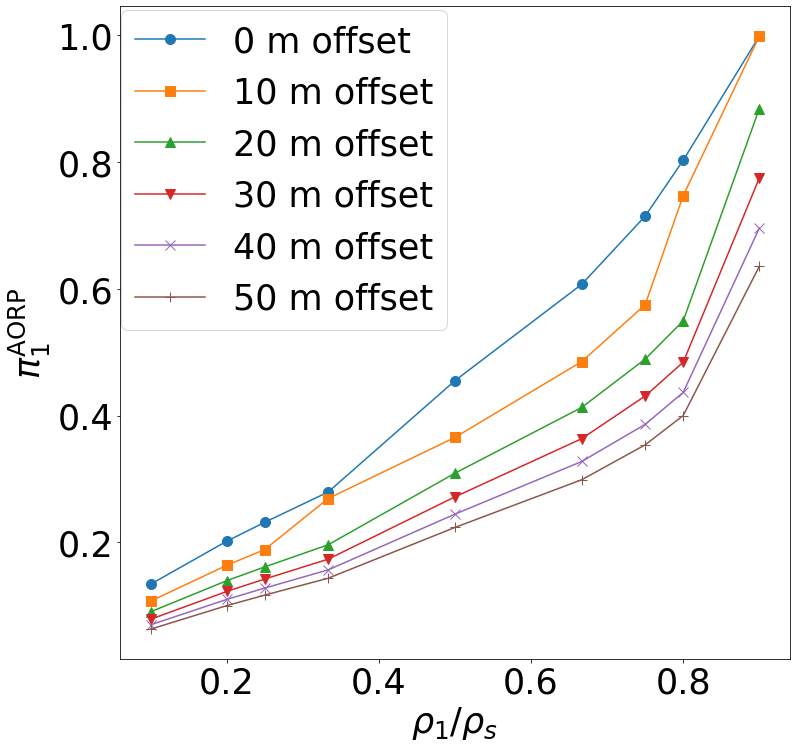

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


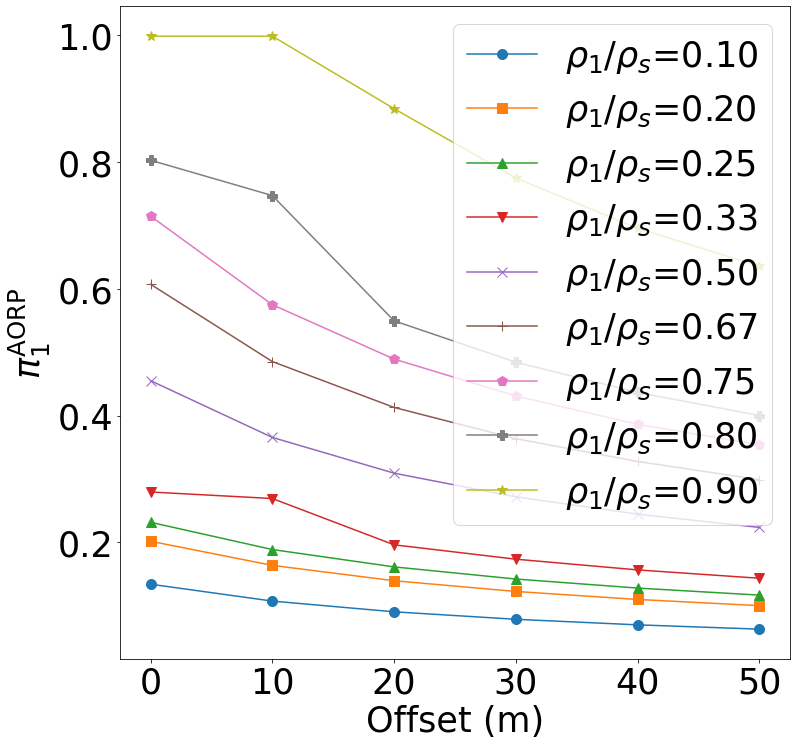

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


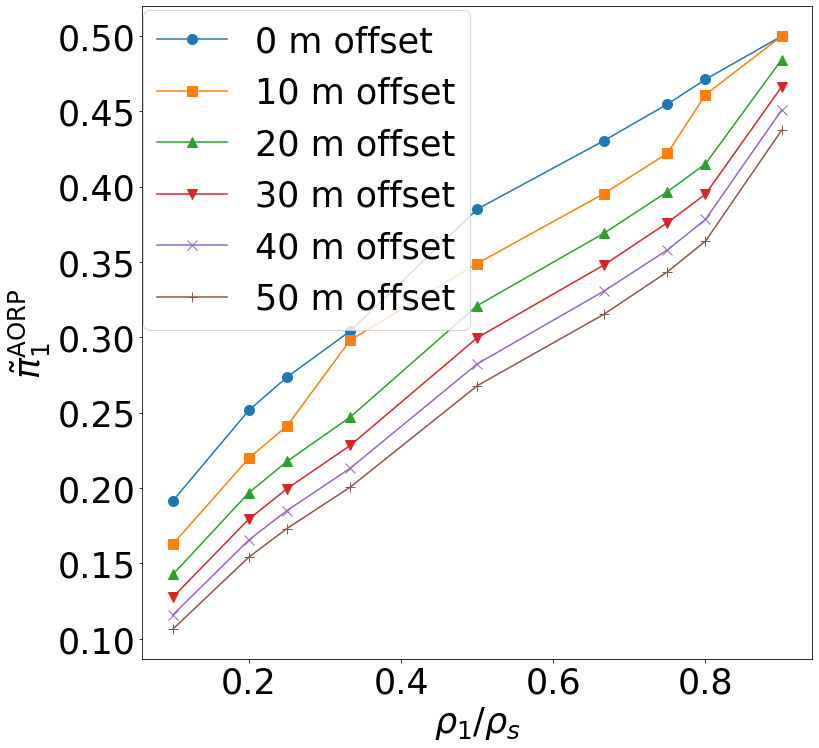

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


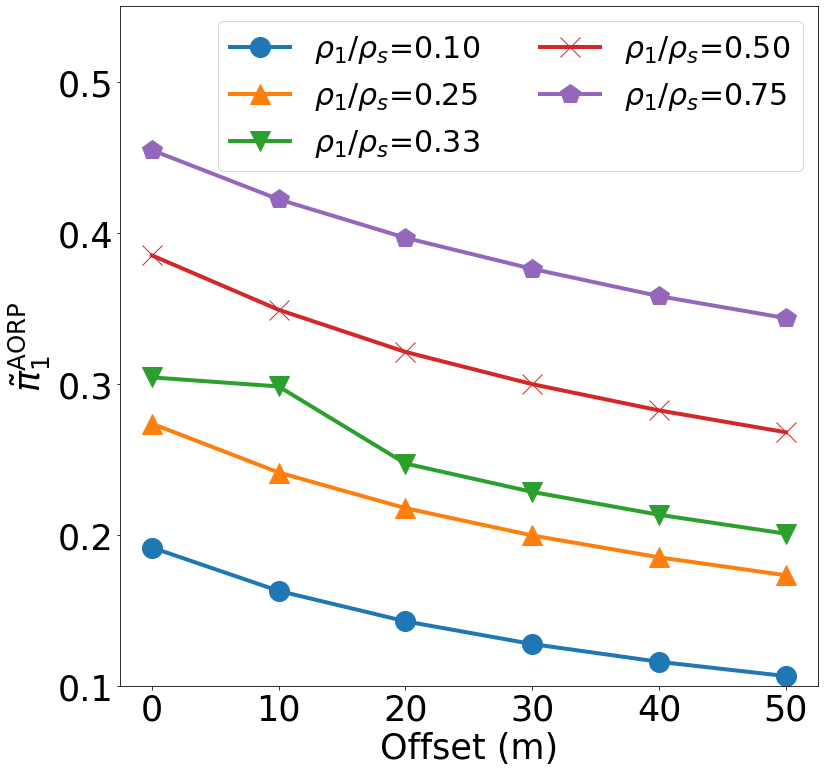

In [27]:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    "font.size": 35
    })


markers = ["o", "s", "^", "v", "x", "+", "p", "P", "*"]
ms = 10

fig = plt.figure(figsize =(12,12))
for i in range(n_steps):
    plt.plot(rho1_percents, pi1s[i,:], "-"+markers[i], markersize=ms, label="%d m offset"%(l[i]))
plt.ylabel("$\\pi_1^{\\mathrm{AORP}}$")
plt.xlabel("$\\rho_1/\\rho_s$")
plt.legend(loc="upper center", bbox_to_anchor=[0.245,1.021])
# plt.title("AORP Visit Frequency vs $\\lambda_1$")
plt.savefig('fig4_pi1_v_lambda.png', format='png', bbox_inches='tight')
plt.savefig('fig4_pi1_v_lambda.eps', format='eps', bbox_inches='tight')
plt.show()


fig = plt.figure(figsize =(12,12))
for j in range(n_vals):
    plt.plot(l, pi1s[:,j], "-"+markers[j], markersize=ms, label="$\\rho_1/\\rho_s$=%.2f"%(rho1_percents[j]))   
plt.ylabel("$\\pi_1^{\\mathrm{AORP}}$")
plt.xlabel("Offset (m)")
plt.legend(loc="upper right")#, bbox_to_anchor=[1,0.9])
# plt.title("AORP Visit Frequency vs Offset")
plt.savefig('fig4_pi1_v_offset.png', format='png', bbox_inches='tight')
plt.savefig('fig4_pi1_v_offset.eps', format='eps', bbox_inches='tight')
plt.show()



fig = plt.figure(figsize =(12,12))
for i in range(n_steps):
    plt.plot(rho1_percents, pi1s_obs[i,:], "-"+markers[i], markersize=ms, label="%d m offset"%(l[i]))
plt.ylabel("$\\tilde{\\pi}_1^{\\mathrm{AORP}}$")
plt.xlabel("$\\rho_1/\\rho_s$")
plt.legend(loc="upper center", bbox_to_anchor=[0.245,1.021])
# plt.title("AORP Visit Frequency vs $\\lambda_1$")
plt.savefig('fig4_pi1obs_v_lambda.png', format='png', bbox_inches='tight')
plt.savefig('fig4_pi1obs_v_lambda.eps', format='eps', bbox_inches='tight')
plt.show()


fig = plt.figure(figsize =(12.5,12.5))
series = [0, 2, 3, 4, 6]
for j in series:
    #plt.plot(l, pi1s_obs[:,j], "-"+markers[j], markersize=ms, label="$\\lambda_1$=%.2f"%(scale[j]*base))   
    plt.plot(l, pi1s_obs[:,j], "-"+markers[j], markersize=ms+10, linewidth=4, label="$\\rho_1/\\rho_s$=%.2f"%(rho1_percents[j]))
plt.ylabel("$\\tilde{\\pi}_1^{\\mathrm{AORP}}$")
plt.xlabel("Offset (m)")
plt.ylim(0.1, 0.55)
plt.legend(loc="upper right", ncol=2, prop={"size":30})#, bbox_to_anchor=[1,0.9])
# plt.title("AORP Visit Frequency vs Offset")
plt.savefig('fig4_pi1obs_v_offset.png', format='png', bbox_inches='tight')
plt.savefig('fig4_pi1obs_v_offset.eps', format='eps', bbox_inches='tight')
plt.show()

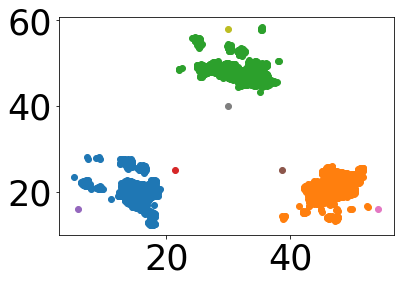

In [45]:
offset = -1*np.array([ -21.65063509,  -12.5 ])
# dt_sys.shiftRegion(0, -offset)#move back
# tjcps[0] -= offset
# pjcps[0] -= offset
# qBase[0] -= offset
# qBase[1] -= offset
for points in tjcps:
    plt.scatter(points[:,0], points[:,1])
    
for qb in qBase:
    plt.scatter(qb[0], qb[1])